In [2]:
import pandas
import numpy 
import numpy.linalg as la
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [3]:
data = pandas.read_csv('../data/hurr_database/atlantic.csv')

In [4]:
data.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'],
      dtype='object')

In [5]:
location = data[["ID", "Name","Latitude", "Longitude"]]

In [11]:
hurr_KATE = location[location["ID"] == 'AL122015']
hurr_KATE

,ID,Name,Latitude,Longitude
49085,AL122015,KATE,22.2N,71.5W
49086,AL122015,KATE,22.8N,72.6W
49087,AL122015,KATE,23.4N,73.7W
49088,AL122015,KATE,24.1N,74.8W
49089,AL122015,KATE,25.0N,75.7W
49090,AL122015,KATE,26.4N,76.2W
49091,AL122015,KATE,28.0N,76.2W
49092,AL122015,KATE,29.5N,75.4W
49093,AL122015,KATE,31.2N,74.0W
49094,AL122015,KATE,33.1N,71.3W


In [12]:
lat = list(hurr_KATE['Latitude'])
lon = list(hurr_KATE['Longitude'])
for i in range(0,len(hurr_KATE)):
    l = lat[i]
    lo = lon[i]
    if l[-1] == 'S':
        lat[i] = '-' + l[:-1]
    else:
        lat[i] = l[:-1]

    if lo[-1] == 'W':
        lon[i] = '-' + lo[:-1]
    else:
        lon[i] = lo[:-1]

In [31]:
lat_in_radians = [radians(float(_)) for _ in lat]
lon_in_radians = [radians(float(_)) for _ in lon]
coords = list(zip(lat_in_radians, lon_in_radians))
coords

[(0.38746309394274114, -1.2479104151759457),
 (0.39793506945470714, -1.2671090369478832),
 (0.40840704496667307, -1.286307658719821),
 (0.42062434973063345, -1.3055062804917585),
 (0.4363323129985824, -1.3212142437597074),
 (0.460766922526503, -1.3299408900196792),
 (0.4886921905584123, -1.3299408900196792),
 (0.5148721293383273, -1.3159782560037245),
 (0.5445427266222308, -1.2915436464758039),
 (0.5777039824101231, -1.2444197566719568),
 (0.6143558967020041, -1.1798425743481666),
 (0.6318091892219474, -1.090830782496456),
 (0.6562437987498679, -1.0157816246606999),
 (0.6789330790257941, -0.9599310885968813),
 (0.6981317007977318, -0.9075712110370514),
 (0.7208209810736581, -0.8796459430051421),
 (0.7312929565856241, -0.8709192967451704),
 (0.7243116395776468, -0.8587019919812102),
 (0.7120943348136864, -0.8290313946973066),
 (0.7103490055616922, -0.7923794804054256)]

In [40]:
print(list(coords[0]))
nass = list((radians(25.0443), radians(-77.3504)))

[0.38746309394274114, -1.2479104151759457]


In [50]:
for i in range(0, len(lat_in_radians)):
    print((haversine_distances([list(coords[i]), nass])[1,0]) * 6371000/1000)

674.617885428788
543.4586471679356
412.83537695990276
278.4564621188874
166.363988954215
189.74847225186627
348.01122335344286
531.5981106559171
759.1261199268953
1070.9595008307303
1466.116213502429
1882.0018498060126
2285.1207278036136
2599.0870547476234
2883.768305737264
3070.335883288987
3138.2342351064735
3169.602923619213
3266.211086774145
3426.2130321011646


In [7]:
current_storm = pandas.read_json("https://www.nhc.noaa.gov/CurrentStorms.json")

In [8]:
current_storm

,activeStorms
0,"{'id': 'al152021', 'binNumber': 'AT5', 'name':..."


In [9]:
current_storm = pandas.json_normalize(current_storm['activeStorms'])

In [19]:
current_storm.columns

Index(['id', 'binNumber', 'name', 'classification', 'intensity', 'pressure',
       'latitude', 'longitude', 'latitudeNumeric', 'longitudeNumeric',
       'movementDir', 'movementSpeed', 'lastUpdate', 'windWatchesWarnings',
       'stormSurgeWatchWarningGIS', 'potentialStormSurgeFloodingGIS',
       'publicAdvisory.advNum', 'publicAdvisory.issuance',
       'publicAdvisory.url', 'forecastAdvisory.advNum',
       'forecastAdvisory.issuance', 'forecastAdvisory.url',
       'windSpeedProbabilities.advNum', 'windSpeedProbabilities.issuance',
       'windSpeedProbabilities.url', 'forecastDiscussion.advNum',
       'forecastDiscussion.issuance', 'forecastDiscussion.url',
       'forecastGraphics.advNum', 'forecastGraphics.issuance',
       'forecastGraphics.url', 'forecastTrack.advNum',
       'forecastTrack.issuance', 'forecastTrack.zipFile',
       'forecastTrack.kmzFile', 'trackCone.advNum', 'trackCone.issuance',
       'trackCone.zipFile', 'trackCone.kmzFile', 'initialWindExtent.advNum',

In [66]:
fp = "../data/AL152021_lin.shp"
line = gpd.read_file(fp)

In [67]:
line

,geometry
0,"LINESTRING (-70.00000 24.20000, -70.60000 24.9..."
1,"LINESTRING (-74.30000 30.40000, -74.70000 31.5..."
2,"LINESTRING (-72.60000 36.00000, -71.40000 36.7..."


<AxesSubplot:>

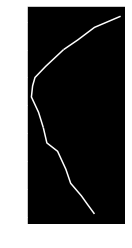

In [68]:
%matplotlib inline
line.plot()